In [22]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
import scipy.stats as stats
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

In [23]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [24]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y))**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j]))**2))/(2*N**2)
    return ES/sum(y)

In [25]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    #flu surveillance data
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions



In [26]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [6]:
pd.__version__

'1.4.4'

Pull surveillance data

In [10]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations


,date,location,location_name,value,weekly_rate
0,2024-02-17,02,Alaska,2.0,0.272700
1,2024-02-17,01,Alabama,120.0,2.349041
2,2024-02-17,05,Arkansas,258.0,8.410122
3,2024-02-17,04,Arizona,204.0,2.745129
4,2024-02-17,06,California,342.0,0.877706
...,...,...,...,...,...
8051,2023-04-08,04,Arizona,40.0,0.538261
8052,2023-04-08,06,California,45.0,0.115488
8053,2023-04-08,08,Colorado,7.0,0.119096
8054,2023-04-08,09,Connecticut,22.0,0.608209


In [125]:
# save surveillance data
observations.to_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq", index=False)

Pull Flu Scenario Modeling Hub data for all models

In [8]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel','MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
          'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha','UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4

for model in models:
    predictions = pull_flu_scenario_modeling_hub_predictions(model,dates)
    predictions['Model'] = model
    
    predictions = predictions[predictions['target'] =='inc hosp']


    numweeks = list(predictions.horizon.unique())

    start_date = list(predictions.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates})


    df = predictions.merge(dfdates, how='inner', on='horizon')


    df.to_parquet(f'../fludat/{model}_rd{rd}.pq', index=False)
    
    

In [ ]:
# save into one dataframe

In [3]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4


In [4]:
predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    print(model, len(df.location.unique())) 
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


remove models with only one location

In [8]:
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

predictionsall = predictionsall[~predictionsall['Model'].isin(singleloc_models)]

In [13]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime('2024-04-27')]

In [14]:
predictions_traj

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date
0,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,1.0,0-130,3.000000,MOBS_NEU-GLEAM_FLU,2023-09-09
1,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,2.0,0-130,13.000000,MOBS_NEU-GLEAM_FLU,2023-09-09
2,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,3.0,0-130,20.000000,MOBS_NEU-GLEAM_FLU,2023-09-09
3,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,4.0,0-130,8.000000,MOBS_NEU-GLEAM_FLU,2023-09-09
4,2023-09-03,A-2023-08-14,inc hosp,1.0,01,sample,5.0,0-130,12.000000,MOBS_NEU-GLEAM_FLU,2023-09-09
...,...,...,...,...,...,...,...,...,...,...,...
1040395,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,96,0-130,11386.833555,UT-ImmunoSEIRS,2024-04-27
1040396,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,97,0-130,10189.685771,UT-ImmunoSEIRS,2024-04-27
1040397,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,98,0-130,6137.291993,UT-ImmunoSEIRS,2024-04-27
1040398,2023-09-03,F-2023-08-14,inc hosp,34.0,US,sample,99,0-130,5867.128822,UT-ImmunoSEIRS,2024-04-27


# Calculate scores

Calculate energy score for each model, scenario, and location

In [138]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            
start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()


predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

for model in predictions_traj.Model.unique():
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_traj[(predictions_traj.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_traj.location == loc) & \
                                        (predictions_traj.Model == model) & \
                                        (predictions_traj.target_end_date <= max_date) & \
                                        (predictions_traj.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = energyscore(np.array(X),y)
        

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



In [139]:
energyscoresdf.to_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")

calculate normalized energy score for each model, scenario, and location

In [140]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            
start_week = pd.to_datetime('2023-09-09')

max_date = pd.to_datetime(observations.date.max())

models = ['MOBS_NEU-GLEAM_FLU', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS']


energyscoresdf_norm = pd.DataFrame()


predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

for model in models:
    for loc in predictions_traj.location.unique():
        
        if loc in ['60','66','69', '72', '78']:
            continue
        
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs
                

            observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,100)]

            predictionsfilt = predictions_traj[(predictions_traj.scenario_id == scenario + '-2023-08-14') & \
                                        (predictions_traj.location == loc) & \
                                        (predictions_traj.Model == model) & \
                                        (predictions_traj.target_end_date <= max_date) & \
                                        (predictions_traj.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue
        
            observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            #filter location
            observations = observations[observations['location'] == loc]


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = normalized_energyscore(np.array(X),y)
        

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            newrow = pd.DataFrame({'Model':model,'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf_norm = pd.concat([energyscoresdf_norm, newrow])

energyscoresdf_norm = energyscoresdf_norm.reset_index()
energyscoresdf_norm = energyscoresdf_norm.drop(columns=['index'])   


energyscoresdf_norm = pd.merge(energyscoresdf_norm, locations, how = 'inner', on = 'location')

In [141]:
energyscoresdf_norm.to_pickle("../fludat/energyscore_norm_individual_rd4_hosp_115.pkl")


Calculate WIS from quantiles estimated from model trajectories for each model, scenario, and location averaged over the full influenza season

In [53]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']


wisdf_traj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

loclist = list(predictionsall.location.unique())
for model in modelsall:

    for loc in loclist:
    
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.target == 'inc ' + target)  & \
                                        (predictionsall.target_end_date <= max_date) & \
                                        (predictionsall.target_end_date >= start_week) &\
                                        (predictionsall.Model == model)]

            if len(predictionsfilt)==0:
                continue
            
            observations = format_observations(location=location)

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2] - y)

            WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'WIS':WIS, 
                                'target':target}, index=[0])

            wisdf_traj = pd.concat([wisdf_traj, newrow])



wisdf_traj = wisdf_traj.reset_index()
wisdf_traj = wisdf_traj.drop(columns=['index'])   


wisdf_traj = pd.merge(wisdf_traj, locations, how = 'inner', on = 'location')


#samplewisdf.to_pickle(f'./samplewis/wis_ensemble_rd17_hosp_trajectory.pkl')



In [54]:
wisdf_traj.to_pickle("../fludat/wis_trajectory_indiv_rd4_hosp_1115.pkl")

Calculate normalized WIS from quantiles estimated from model trajectories for each model, scenario, and location averaged over the full influenza season. Divide averaged WIS by sum of surveillance data to normalize

In [28]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})
target_obs = 'hospitalization'
incidence= True
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']


wisdf_traj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

loclist = list(predictionsall.location.unique())
for model in modelsall:

    for loc in loclist:
    
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.target == 'inc ' + target)  & \
                                        (predictionsall.target_end_date <= max_date) & \
                                        (predictionsall.target_end_date >= start_week) &\
                                        (predictionsall.Model == model)]

            if len(predictionsfilt)==0:
                continue
            
            observations = format_observations(location=location)

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2] - y)

            WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)
            
            WIS = WIS / sum(y)

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'WIS':WIS, 
                                'target':target}, index=[0])

            wisdf_traj = pd.concat([wisdf_traj, newrow])



wisdf_traj = wisdf_traj.reset_index()
wisdf_traj = wisdf_traj.drop(columns=['index'])   


wisdf_traj = pd.merge(wisdf_traj, locations, how = 'inner', on = 'location')


#samplewisdf.to_pickle(f'./samplewis/wis_ensemble_rd17_hosp_trajectory.pkl')



In [29]:
wisdf_traj.to_pickle("../fludat/wis_norm_trajectory_indiv_rd4_hosp.pkl")

calculate WIS by estimating quantiles from trajectories at each week of the influenza season for each model, scenario, and location

In [56]:
locations = pd.read_csv('../fludat/locations.csv',dtype={'location':str})

observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']


wisdf_traj = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

loclist = list(predictionsall.location.unique())
for model in predictionsall.Model.unique():
    print(model)
    for loc in loclist:
    
        if loc in ['60','66','69', '72', '78']:
            continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
            
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                        (predictionsall.location == location) & \
                                        (predictionsall.target == 'inc ' + target)  & \
                                        (predictionsall.target_end_date <= observations.date.max()) & \
                                        (predictionsall.target_end_date >= pd.to_datetime('2023-09-09')) &\
                                        (predictionsall.Model == model)]

            if len(predictionsfilt)==0:
                continue

            observations = format_observations(location=location)
           
            if len(observations)==0:
                continue

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2 ] - y)

            WISlist = np.array(WIS) / (len(quantiles) // 2 + 0.5)
            dates = list(predictionsfilt.target_end_date.unique())

            if loc == 'US':
                loc_conv = loc
            elif int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc  

            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 
                                   'WIS':WISlist, 'target':target, 'target_end_date':dates})

            wisdf_traj = pd.concat([wisdf_traj, newrow])


wisdf_traj = wisdf_traj.reset_index()
wisdf_traj = wisdf_traj.drop(columns=['index'])   



CADPH-FluCAT
CDDEP-FluCompModel
MOBS_NEU-GLEAM_FLU
NIH-FluD
NIH-Flu_TS
NotreDame-FRED
PSI-M2
USC-SIkJalpha
UT-ImmunoSEIRS
UVA-FluXSim


In [57]:
wisdf_traj.to_pickle('../fludat/wis_timestamp_traj_1115.pkl') 

In [58]:
wisdf_traj

,Model,Label,location,WIS,target,target_end_date
0,CADPH-FluCAT,Scenario A,6,20.340515,hosp,2023-09-09
1,CADPH-FluCAT,Scenario A,6,36.920726,hosp,2023-09-16
2,CADPH-FluCAT,Scenario A,6,55.169233,hosp,2023-09-23
3,CADPH-FluCAT,Scenario A,6,105.135587,hosp,2023-09-30
4,CADPH-FluCAT,Scenario A,6,183.894648,hosp,2023-10-07
...,...,...,...,...,...,...
56299,UVA-FluXSim,Scenario F,US,5250.341195,hosp,2024-03-30
56300,UVA-FluXSim,Scenario F,US,4850.540318,hosp,2024-04-06
56301,UVA-FluXSim,Scenario F,US,3904.476868,hosp,2024-04-13
56302,UVA-FluXSim,Scenario F,US,2831.914347,hosp,2024-04-20


# Analysis

plots comparing energy score and WIS values

In [31]:
models = ['MOBS_NEU-GLEAM_FLU', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS']

modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F',
            'Trajectory Ensemble': 'Trajectory Ensemble'}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


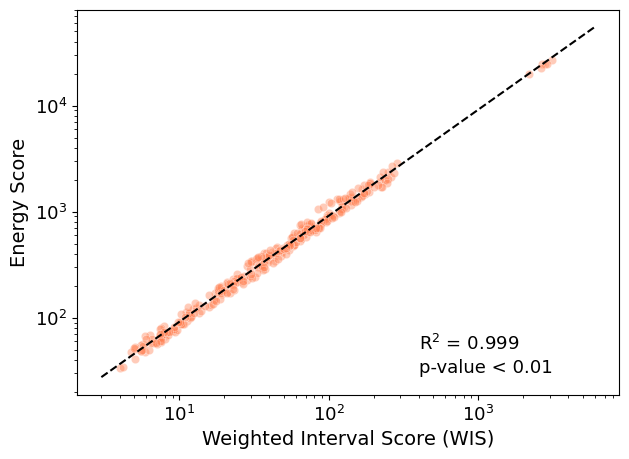

In [151]:
fig, axes = plt.subplots(figsize=(7,5))
rd = 4
es = pd.read_pickle('../fludat/energyscore_individual_rd4_hosp_521.pkl')

wisdf = pd.read_pickle("../fludat/wis_trajectory_indiv_rd4_hosp_1115.pkl")

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

es =es[es.Model=='MOBS_NEU-GLEAM_FLU']
wisdf =  wisdf[wisdf.Model == 'MOBS_NEU-GLEAM_FLU']
    
allscores = es.merge(wisdf, on=['location', 'Label','Model']).dropna()
allscores['modelmap'] = allscores['Model'].apply(lambda x: modelmap[x])
allscores = allscores.sort_values(by='modelmap')

sns.scatterplot(data=allscores, x='WIS', y='energyscore', color='coral', alpha=.4)

slope, intercept, r_value, p_value, std_err = linregress(allscores.WIS, allscores.energyscore,
                                                        alternative='two-sided')

logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(allscores.WIS), 
                                                                        np.log10(allscores.energyscore),
                                                                       alternative='two-sided')
print(p_value)

xval = np.linspace(3, 6000, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(400,50, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=13)
plt.text(400,30, r'p-value < 0.01', fontsize=13)


plt.xlabel('Weighted Interval Score (WIS)', fontsize=14)
plt.ylabel('Energy Score', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.savefig('../figs/ESvsWIS_MOBS_1115.pdf')
plt.show()

In [111]:
p_value

0.0

Correlation between normalized scores

1.3834483287034296e-116Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



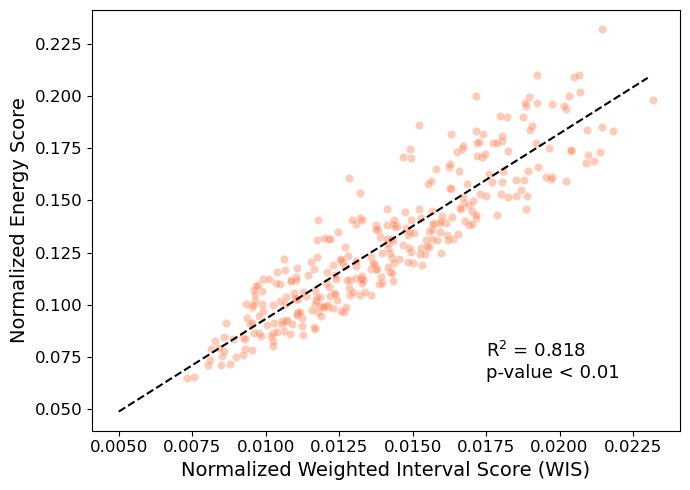

In [84]:
fig, axes = plt.subplots(figsize=(7,5))
rd = 4
es = pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_115.pkl")

wisdf = pd.read_pickle("../fludat/wis_norm_trajectory_indiv_rd4_hosp.pkl")

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

es =es[es.Model=='MOBS_NEU-GLEAM_FLU']
wisdf =  wisdf[wisdf.Model == 'MOBS_NEU-GLEAM_FLU']
    
allscores = es.merge(wisdf, on=['location', 'Label','Model']).dropna()
allscores['modelmap'] = allscores['Model'].apply(lambda x: modelmap[x])
allscores = allscores.sort_values(by='modelmap')

sns.scatterplot(data=allscores, x='WIS', y='energyscore', color='coral', alpha=.4)

slope, intercept, r_value, p_value, std_err = linregress(allscores.WIS, allscores.energyscore,
                                                        alternative='two-sided')

print(p_value)

xval = np.linspace(0.005, .023, 100)
yval = slope*xval+intercept

plt.plot(xval, yval, '--',color='k')


plt.text(.0175,.075, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=13)
plt.text(.0175,.065, r'p-value < 0.01', fontsize=13)


plt.xlabel('Normalized Weighted Interval Score (WIS)', fontsize=14)
plt.ylabel('Normalized Energy Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.xscale("log")
#plt.yscale("log")

plt.tight_layout()
plt.savefig('../figs/ESvsWIS_norm_MOBS_0626.pdf')
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1.891122945559493e-24
3.0537858563999955e-16
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1.5871435465621346e-25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
4.908301198190735e-16
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Lib

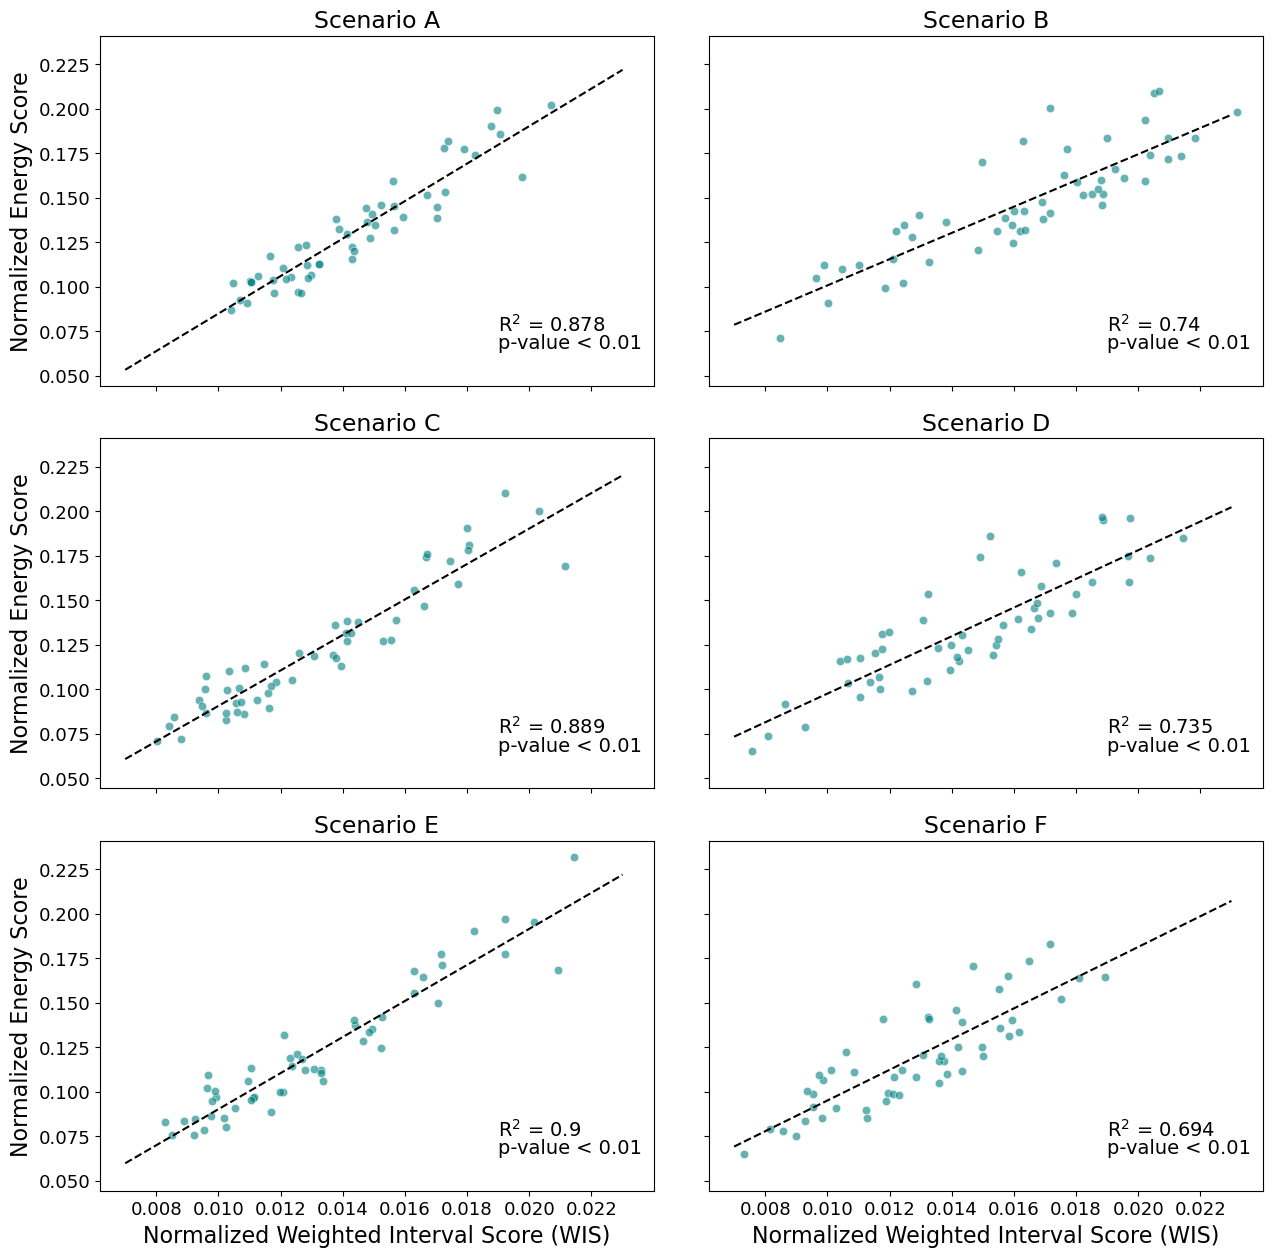

In [170]:
fig, axes = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True)
rd = 4
es = pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_115.pkl")

wisdf = pd.read_pickle("../fludat/wis_norm_trajectory_indiv_rd4_hosp.pkl")

cmap = plt.get_cmap('Set2', 10)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

es =es[es.Model=='MOBS_NEU-GLEAM_FLU']
wisdf =  wisdf[wisdf.Model == 'MOBS_NEU-GLEAM_FLU']
    
allscores = es.merge(wisdf, on=['location', 'Label','Model']).dropna()
allscores['modelmap'] = allscores['Model'].apply(lambda x: modelmap[x])
allscores = allscores.sort_values(by='modelmap').sort_values(by='Label')

i=1
for label in allscores.Label.unique():

    plt.subplot(3,2,i)
    df = allscores[allscores.Label== label]

    sns.scatterplot(data=df, x='WIS', y='energyscore', alpha=.6,color='teal')


    slope, intercept, r_value, p_value, std_err = linregress(df.WIS, df.energyscore,
                                                            alternative='two-sided')
    print(p_value)

    xval = np.linspace(0.007, .023, 100)
    yval = slope*xval+intercept


    plt.plot(xval, yval, '--',color='k')


    plt.text(.019,.075, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=14)
    plt.text(.019,.065, r'p-value < 0.01', fontsize=14)

    plt.title(label,fontsize=17)

    plt.xlabel('Normalized Weighted Interval Score (WIS)', fontsize=16)
    plt.ylabel('Normalized Energy Score', fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    i+=1

#plt.xscale("log")
#plt.yscale("log")

#plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.15) # Adjust as needed
plt.savefig('../figs/ESvsWIS_MOBS_norm_allscenarios.pdf')
plt.show()

# Energy score vs sum of observations

In [142]:
energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['location'] = energyscoresdf['location'].apply(lambda x: '0'+x if len(x)<2 else x)



energyscoresdf_norm =pd.read_pickle("../fludat/energyscore_norm_individual_rd4_hosp_115.pkl")
energyscoresdf_norm['location'] = energyscoresdf_norm['location'].apply(lambda x: '0'+x if len(x)<2 else x)


In [143]:
incidence=True
target_obs='hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] >= start_week) & \
                                        (observations['date'] <= max_date)]   

            
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

observations = observations[['location','date','value']]

In [293]:
observations.groupby('location').sum().to_pickle('../fludat/flu_obs_hosp_sum.pkl')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1.66140637675345e-290
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


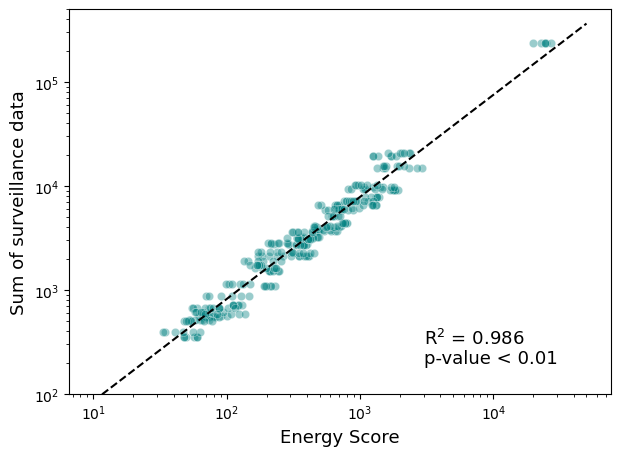

In [146]:
plt.subplots(1,1,figsize=(7,5))

obs_sum = pd.read_pickle('../fludat/flu_obs_hosp_sum.pkl').rename(columns={'value':'sum_val'})

energyscoredf = energyscoresdf[(energyscoresdf.Model == 'MOBS_NEU-GLEAM_FLU') ].dropna()
energyscoredfnorm = energyscoresdf_norm[(energyscoresdf_norm.Model =='MOBS_NEU-GLEAM_FLU') ].dropna()

energyscoredf['modelmap'] = energyscoredf['Model'].apply(lambda x: modelmap[x])
energyscoredf = energyscoredf.sort_values(by='modelmap')
energyscoredf = energyscoredf.merge(obs_sum, on=['location']).sort_values(by='modelmap')

energyscoredfnorm['modelmap'] = energyscoredfnorm['Model'].apply(lambda x: modelmap[x])
energyscoredfnorm = energyscoredfnorm.sort_values(by='modelmap')
energyscoredfnorm = energyscoredfnorm.merge(obs_sum, on=['location']).sort_values(by='modelmap')

sns.scatterplot(data=energyscoredf, x='energyscore', y='sum_val', color='teal', alpha=.4)


plt.xlabel('Energy Score', fontsize=13)
plt.ylabel('Sum of surveillance data', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredf.energyscore, energyscoredf.sum_val,
                                                        alternative='two-sided')
    
logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(energyscoredf.energyscore), 
                                                                            np.log10(energyscoredf.sum_val),
                                                                           alternative='two-sided')  
    
xval = np.linspace(10, 50000, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(3000,300, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=13)
plt.text(3000,200, r'p-value < 0.01', fontsize=13)

print(p_value)

plt.ylim([100, 5e5])

plt.xscale('log')
plt.yscale('log')

#plt.savefig('../figs/sumobs_ES_1211.pdf')

0.01868264486559002Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


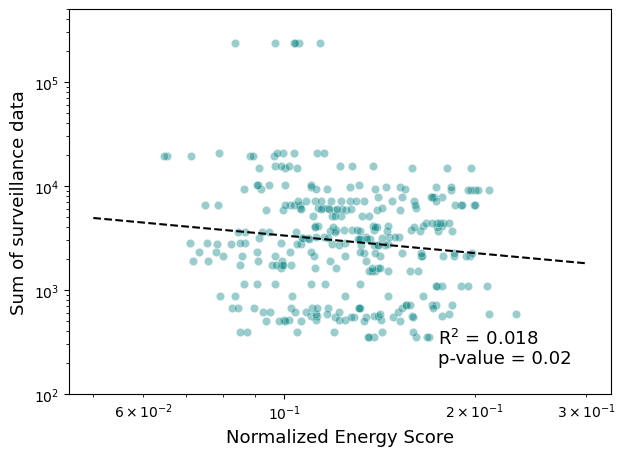

In [147]:
plt.subplots(1,1,figsize=(7,5))

obs_sum = pd.read_pickle('../fludat/flu_obs_hosp_sum.pkl').rename(columns={'value':'sum_val'})

energyscoredf = energyscoresdf[(energyscoresdf.Model == 'MOBS_NEU-GLEAM_FLU') ].dropna()
energyscoredfnorm = energyscoresdf_norm[(energyscoresdf_norm.Model =='MOBS_NEU-GLEAM_FLU') ].dropna()

energyscoredf['modelmap'] = energyscoredf['Model'].apply(lambda x: modelmap[x])
energyscoredf = energyscoredf.sort_values(by='modelmap')
energyscoredf = energyscoredf.merge(obs_sum, on=['location']).sort_values(by='modelmap')

energyscoredfnorm['modelmap'] = energyscoredfnorm['Model'].apply(lambda x: modelmap[x])
energyscoredfnorm = energyscoredfnorm.sort_values(by='modelmap')
energyscoredfnorm = energyscoredfnorm.merge(obs_sum, on=['location']).sort_values(by='modelmap')


sns.scatterplot(data=energyscoredfnorm, x='energyscore', y='sum_val', color='teal', alpha=.4)


plt.xlabel('Normalized Energy Score', fontsize=13)
plt.ylabel('Sum of surveillance data', fontsize=13)

slope, intercept, r_value, p_value, std_err = linregress(energyscoredfnorm.energyscore, energyscoredfnorm.sum_val,
                                                        alternative='two-sided')
    
logslope, logintercept, logr_value, logp_value, logstd_err = linregress(np.log10(energyscoredfnorm.energyscore), 
                                                                            np.log10(energyscoredfnorm.sum_val),
                                                                           alternative='two-sided')
    
    
xval = np.linspace(.05, .3, 100)
yval = 10**(logslope*np.log10(xval)+logintercept)

plt.plot(xval, yval, '--',color='k')


plt.text(.175,300, r'R$^2$ = '+str(round(r_value**2, 3)), fontsize=13)
plt.text(.175,200, f'p-value = {round(p_value,2)}', fontsize=13)

print(p_value)

plt.ylim([100, 5e5])

plt.xscale('log')
plt.yscale('log')

#plt.savefig('../figs/sumobs_ESnorm_1211.pdf')

# Compare SMH projections with baseline model for all models

In [13]:
# download baseline model energy score 

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore_118.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'
energyscoresdf['location'] = energyscoresdf['location'].apply(lambda x: '0'+x if len(x)<2 else x)


# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']

In [14]:
models = ['MOBS_NEU-GLEAM_FLU', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS']

modelmap = {'MOBS_NEU-GLEAM_FLU':'Model I', 'NIH-Flu_TS': 'Model II','NotreDame-FRED':'Model III',
            'PSI-M2':'Model IV', 'USC-SIkJalpha':'Model V', 'UT-ImmunoSEIRS':'Model VI',
            'Trajectory Ensemble': 'Trajectory Ensemble'}

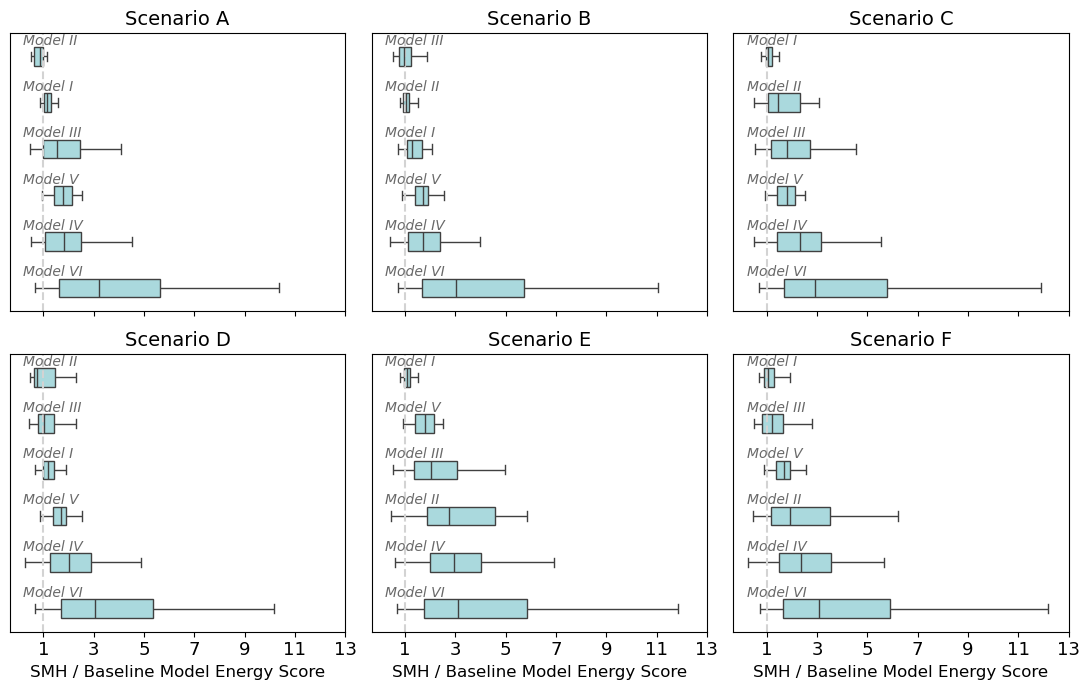

In [15]:
fig, ax = plt.subplots(2,3,figsize=(11,7), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in ES_ratiodf.Label.unique():
    plt.subplot(2,3,i)
    
    if i<4:
        x = 0
    else:
        x=1

        
    if i in [1,4]:
        y=0
    elif i in [2,5]:
        y=1
    else:
        y=2
    
    rankinfo = ES_ratiodf[ES_ratiodf.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["ES_ratio"].median().sort_values(ascending=True).index
    
    g = sns.boxplot(x='ES_ratio', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4,
                   showfliers=False)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 4]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [4,5,6]:
        plt.xlabel('SMH / Baseline Model Energy Score', fontsize=12)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
   # plt.xlim([0, 2.5])
    
    
    for patch in ax[x][y].patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .4))

    
    plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)

    
    a = 0
    for mod in list(my_order):
        plt.text(0.2,a-.25, modelmap[mod], fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks([1,3,5,7,9,11,13],fontsize=13)
plt.tight_layout()
plt.savefig('../figs/ESratio_flurd4_models_h_0530_new.pdf')
plt.show()


In [10]:
ES_ratiodf['Model'] = ES_ratiodf['Model'].apply(lambda x: modelmap[x])

df = ES_ratiodf.groupby(['Label', 'Model']).ES_ratio.describe(percentiles=[.05,.5,.95]).drop(columns=['mean',
                                                         'std']).round(2)

In [11]:
df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n           &          &  count &   min &    5\\% &   50\\% &    95\\% &    max \\\\\nLabel & Model &        &       &       &       &        &        \\\\\n\\midrule\nScenario A & Model I &   52.0 &  0.87 &  0.91 &  1.16 &   1.49 &   1.59 \\\\\n           & Model II &   13.0 &  0.50 &  0.50 &  0.84 &   1.13 &   1.13 \\\\\n           & Model III &   52.0 &  0.48 &  0.60 &  1.55 &   3.40 &   7.04 \\\\\n           & Model IV &   52.0 &  0.51 &  0.65 &  1.80 &   4.90 &   7.48 \\\\\n           & Model V &   52.0 &  0.93 &  1.09 &  1.79 &   2.52 &   4.70 \\\\\n           & Model VI &   51.0 &  0.66 &  0.87 &  3.19 &  12.22 &  16.66 \\\\\nScenario B & Model I &   52.0 &  0.73 &  0.84 &  1.29 &   1.87 &   2.07 \\\\\n           & Model II &   13.0 &  0.79 &  0.81 &  1.02 &   1.55 &   1.61 \\\\\n           & Model III &   52.0 &  0.51 &  0.56 &  0.94 &   2.59 &   4.49 \\\\\n           & Model IV &   52.0 &  0.39 &  0.51 &  1.71 &   3.78 &   4.73 \\\\\n    

# Rankings

In [86]:
# energy score rank

es_all = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")


# standardized rank energy score

dfrankall = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank','target'])

dfa =  es_all.copy()

dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('energyscore')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)

dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()
dfrankallenergyscore = dfrankallenergyscore.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_ES'})


In [85]:
# wis rank

dfa =  pd.read_pickle("../fludat/wis_trajectory_indiv_rd4_hosp_1115.pkl") 
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

dfa = dfa[~dfa['Model'].isin(singleloc_models)]


dfrank = pd.DataFrame(columns=['Model', 'location', 'Standard_Rank', 'target'])

states = list(dfa.location.unique())

for state in states:
    for scenario in dfa.Label.unique():
        filt = dfa[(dfa['location']==state) & (dfa.Label == scenario)]
        filt = filt.sort_values('WIS')

        rank = list(filt.Model)
        for model in rank:
            rankval = rank.index(model)+1

            new_row = {'Model':model, 'location': state, 'Standard_Rank': rankval, 'target':target,  
                      'Label':scenario}

            dfrank = dfrank.append(new_row, ignore_index=True)


dfrankallwis = dfrank.reset_index()
dfrankallwis = dfrankallwis.drop(columns=['index']).rename(columns={'Standard_Rank':'standard_rank_wis'})


In [87]:
dfrankall = dfrankallenergyscore.merge(dfrankallwis, on = ['Model', 'location', 'Label', 'target'])

In [88]:
# calculate kendall tau rank correlation for energy score and WIS
ranks = pd.DataFrame()
for loc in dfrankall.location.unique():
    for scenario in dfrankall.Label.unique():

        df = dfrankall[(dfrankall.location==loc) & (dfrankall.Label==scenario)]
        tau, pval = stats.kendalltau(df.standard_rank_wis, df.standard_rank_ES)
        
        row = pd.DataFrame({'location':loc, 'Label':scenario, 'tau':tau}, index=[0])
        
        ranks = pd.concat([ranks, row])

In [89]:
ranks.mean()  

tau    0.868162
dtype: float64

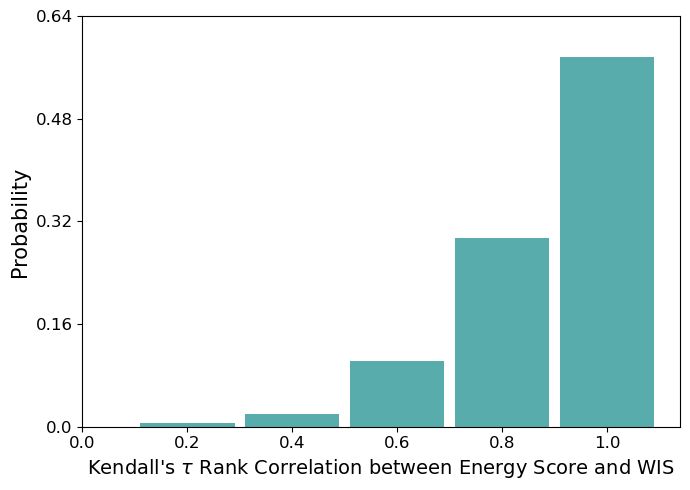

In [91]:
plt.figure(figsize=(7,5))
plt.hist(ranks.tau,bins=5,color='teal', rwidth=.9, alpha=.65, align='right')
plt.xlabel('Kendall\'s'+ r' $\tau$ Rank Correlation'+ ' between Energy Score and WIS', fontsize=14)
plt.ylabel('Probability', fontsize=15)
plt.xticks([0, .2, .4, .6, .8, 1.0], fontsize=12)
plt.yticks([0,50,100,150,200],fontsize=12, labels = [round(i/len(ranks),2) for i in [0,50,100,150,200]])
#plt.yticklabel([i/len(ranks) for i in [0,50,100,150,200]],fontsize=12)

plt.tight_layout()
plt.savefig('../figs/kendalltau_histogram_rank_D_updated_0626.pdf')

In [78]:
(len(ranks[ranks.tau>.99])/len(ranks))*100

49.67948717948718

# Energy score ratio for all locations and multi-dimensional energy score for MOBS 

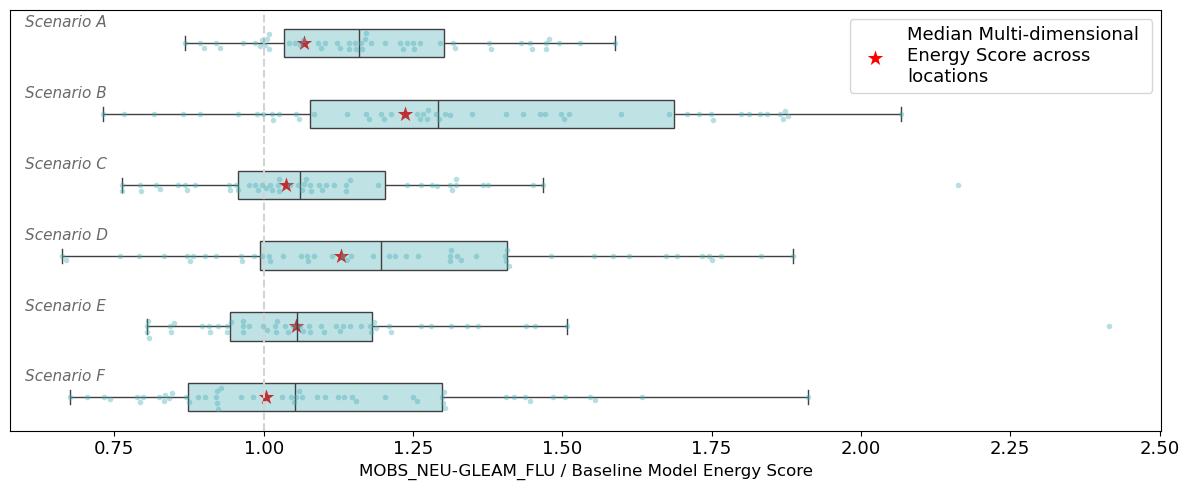

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
#plt.subplots_adjust(hspace=4)
i=1

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore_118.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'
energyscoresdf['location'] = energyscoresdf['location'].apply(lambda x: '0'+x if len(x)<2 else x)

# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']    
rankinfo = ES_ratiodf[(ES_ratiodf.Model == 'MOBS_NEU-GLEAM_FLU')]


my_order = rankinfo.Label.unique()

g = sns.boxplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order, color = '#17B1BF', width=0.4,
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
# plot underlying distribution
sns.swarmplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .4,size=4,
              orient="h")  

g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('MOBS_NEU-GLEAM_FLU / Baseline Model Energy Score', fontsize=12)

i+=1 
#plt.title(scenario, fontsize=14)
#plt.xlim([0, 13])




plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


mobs_multitarget = pd.read_csv('../fludat/multitarget_mobs_ratio_median_1204.csv')

sns.scatterplot(x='ES_ratio',y='Label',data=mobs_multitarget,color='red',s=250,marker='*',
                label='Median Multi-dimensional \nEnergy Score across \nlocations')

plt.legend(fontsize=13)

a = 0
for mod in list(my_order):
    plt.text(0.6,a-.225, mod, fontsize=11, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.tight_layout()

#plt.savefig('../figs/MOBS_ESdist_multi_1211.pdf')
plt.show()


In [134]:
df = rankinfo.groupby(['Label']).ES_ratio.describe(percentiles=[.05,.5,.95]).drop(columns=['mean',
                                                         'std']).round(2)

In [135]:
df

,count,min,5%,50%,95%,max
Label,,,,,,
Scenario A,52.0,0.87,0.91,1.16,1.49,1.59
Scenario B,52.0,0.73,0.84,1.29,1.87,2.07
Scenario C,52.0,0.76,0.79,1.06,1.41,2.16
Scenario D,52.0,0.66,0.78,1.20,1.76,1.89
Scenario E,52.0,0.80,0.81,1.06,1.45,2.42
Scenario F,52.0,0.68,0.74,1.05,1.55,1.91


In [136]:
df.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  count &   min &    5\\% &   50\\% &   95\\% &   max \\\\\nLabel      &        &       &       &       &       &       \\\\\n\\midrule\nScenario A &   52.0 &  0.87 &  0.91 &  1.16 &  1.49 &  1.59 \\\\\nScenario B &   52.0 &  0.73 &  0.84 &  1.29 &  1.87 &  2.07 \\\\\nScenario C &   52.0 &  0.76 &  0.79 &  1.06 &  1.41 &  2.16 \\\\\nScenario D &   52.0 &  0.66 &  0.78 &  1.20 &  1.76 &  1.89 \\\\\nScenario E &   52.0 &  0.80 &  0.81 &  1.06 &  1.45 &  2.42 \\\\\nScenario F &   52.0 &  0.68 &  0.74 &  1.05 &  1.55 &  1.91 \\\\\n\\bottomrule\n\\end{tabular}\n'

# multi-dimensional score with  no normalization factor

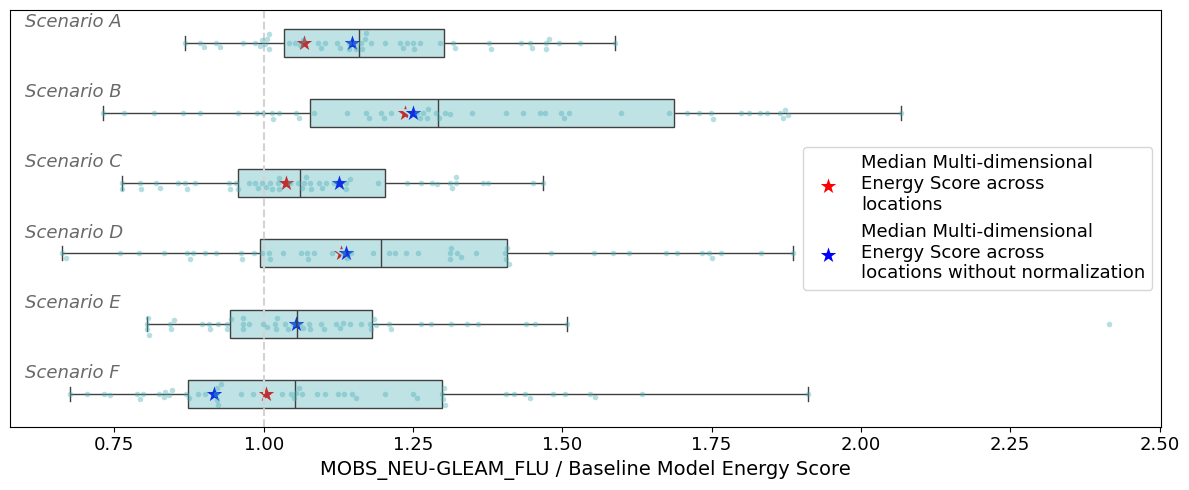

In [107]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
#plt.subplots_adjust(hspace=4)
i=1

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore_118.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_individual_rd4_hosp_521.pkl")
energyscoresdf['target'] = 'inc hosp'
energyscoresdf['location'] = energyscoresdf['location'].apply(lambda x: '0'+x if len(x)<2 else x)

# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']    
rankinfo = ES_ratiodf[(ES_ratiodf.Model == 'MOBS_NEU-GLEAM_FLU')]


my_order = rankinfo.Label.unique()

g = sns.boxplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order, color = '#17B1BF', width=0.4,
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
# plot underlying distribution
sns.swarmplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .4,size=4,
              orient="h")  

g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('MOBS_NEU-GLEAM_FLU / Baseline Model Energy Score', fontsize=14)

i+=1 
#plt.title(scenario, fontsize=14)
#plt.xlim([0, 13])




plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)


mobs_multitarget = pd.read_csv('../fludat/multitarget_mobs_ratio_median_1204.csv')

sns.scatterplot(x='ES_ratio',y='Label',data=mobs_multitarget,color='red',s=250,marker='*',
                label='Median Multi-dimensional \nEnergy Score across \nlocations')

multitarget_no_norm = pd.read_csv('../fludat/multitarget_mobs_ratio_median_no_norm.csv')
sns.scatterplot(x='ES_ratio',y='Label',data=multitarget_no_norm,color='blue',s=250,marker='*',
                label='Median Multi-dimensional \nEnergy Score across \nlocations without normalization')




plt.legend(fontsize=13)

a = 0
for mod in list(my_order):
    plt.text(0.6,a-.225, mod, fontsize=13, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.tight_layout()

plt.savefig('../figs/MOBS_ESdist_multi_no_norm.pdf')
plt.show()